In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt
import pandas_profiling as pp
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold,StratifiedKFold
from sklearn.metrics import mean_squared_error
from catboost import CatBoostRegressor
from catboost import Pool
%matplotlib inline

In [2]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
fulfilment_center = pd.read_csv('fulfilment_center_info.csv')
meal_info = pd.read_csv('meal_info.csv')

In [3]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 456548 entries, 0 to 456547
Data columns (total 9 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
dtypes: float64(2), int64(7)
memory usage: 31.3 MB


In [4]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32573 entries, 0 to 32572
Data columns (total 8 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   id                     32573 non-null  int64  
 1   week                   32573 non-null  int64  
 2   center_id              32573 non-null  int64  
 3   meal_id                32573 non-null  int64  
 4   checkout_price         32573 non-null  float64
 5   base_price             32573 non-null  float64
 6   emailer_for_promotion  32573 non-null  int64  
 7   homepage_featured      32573 non-null  int64  
dtypes: float64(2), int64(6)
memory usage: 2.0 MB


In [5]:
test.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured
0,1028232,146,55,1885,158.11,159.11,0,0
1,1127204,146,55,1993,160.11,159.11,0,0
2,1212707,146,55,2539,157.14,159.14,0,0
3,1082698,146,55,2631,162.02,162.02,0,0
4,1400926,146,55,1248,163.93,163.93,0,0


In [6]:
fulfilment_center.head()

,center_id,city_code,region_code,center_type,op_area
0,11,679,56,TYPE_A,3.7
1,13,590,56,TYPE_B,6.7
2,124,590,56,TYPE_C,4.0
3,66,648,34,TYPE_A,4.1
4,94,632,34,TYPE_C,3.6


In [7]:
meal_info.head()

,meal_id,category,cuisine
0,1885,Beverages,Thai
1,1993,Beverages,Thai
2,2539,Beverages,Thai
3,1248,Beverages,Indian
4,2631,Beverages,Indian


In [8]:
meal_info.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 51 entries, 0 to 50
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   meal_id   51 non-null     int64 
 1   category  51 non-null     object
 2   cuisine   51 non-null     object
dtypes: int64(1), object(2)
memory usage: 1.3+ KB


In [9]:
train = pd.merge(train,fulfilment_center, on='center_id')
test = pd.merge(test,fulfilment_center, on='center_id')

train = pd.merge(train,meal_info, on='meal_id')
test = pd.merge(test,meal_info, on='meal_id')

In [10]:
train.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,region_code,center_type,op_area,category,cuisine
0,1379560,1,55,1885,136.83,152.29,0,0,177,647,56,TYPE_C,2.0,Beverages,Thai
1,1018704,2,55,1885,135.83,152.29,0,0,323,647,56,TYPE_C,2.0,Beverages,Thai
2,1196273,3,55,1885,132.92,133.92,0,0,96,647,56,TYPE_C,2.0,Beverages,Thai
3,1116527,4,55,1885,135.86,134.86,0,0,163,647,56,TYPE_C,2.0,Beverages,Thai
4,1343872,5,55,1885,146.50,147.50,0,0,215,647,56,TYPE_C,2.0,Beverages,Thai


In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 15 columns):
 #   Column                 Non-Null Count   Dtype  
---  ------                 --------------   -----  
 0   id                     456548 non-null  int64  
 1   week                   456548 non-null  int64  
 2   center_id              456548 non-null  int64  
 3   meal_id                456548 non-null  int64  
 4   checkout_price         456548 non-null  float64
 5   base_price             456548 non-null  float64
 6   emailer_for_promotion  456548 non-null  int64  
 7   homepage_featured      456548 non-null  int64  
 8   num_orders             456548 non-null  int64  
 9   city_code              456548 non-null  int64  
 10  region_code            456548 non-null  int64  
 11  center_type            456548 non-null  object 
 12  op_area                456548 non-null  float64
 13  category               456548 non-null  object 
 14  cuisine                456548 non-nu

#### Feature Engineering

In [12]:
train['train_or_test'] = 'train'
test['train_or_test'] = 'test'

In [13]:
train['num_orders'] = np.log1p(train['num_orders'])

In [14]:
total_data = train.append(test).reset_index(drop=True)[train.columns]

In [15]:
total_data = total_data.sort_values(['center_id', 'meal_id', 'week']).reset_index(drop=True)

In [16]:
total_data['checkout_price'] = np.log1p(total_data['checkout_price'])
total_data['base_price'] = np.log1p(total_data['base_price'])

In [17]:
total_data['discount_on_base'] = (total_data['base_price'] - total_data['checkout_price']) / total_data['base_price']

In [18]:
total_data["discount_ratio"] = total_data["base_price"] / total_data["checkout_price"]

In [19]:
sns.distplot(total_data['discount_on_base'], bins=500)
plt.show()

C:\Users\HP\anaconda3\lib\site-packages\ipykernel_launcher.py:2: UserWarning: Matplotlib is currently using agg, which is a non-GUI backend, so cannot show the figure.
  


In [20]:
total_data['price_last_curr_diff'] = (total_data['checkout_price'].shift(1) - total_data['checkout_price']).fillna(1)/ total_data['checkout_price'].shift(1).fillna(1)

In [21]:
for _, r in total_data.groupby(['center_id', 'meal_id'])['week'].first().reset_index().iterrows():
    total_data.loc[(total_data['center_id']==r['center_id']) & (total_data['meal_id']==r['meal_id']) & (total_data['week']==r['week']), 'price_last_curr_diff'] = total_data[(total_data['center_id']==r['center_id']) & (total_data['meal_id']==r['meal_id']) & (total_data['week']!=r['week'])]['price_last_curr_diff'].mean()
total_data['price_last_curr_diff'] = total_data['price_last_curr_diff'].fillna(0)

#### Some functions to create aggregated, rolling mean/median, and exponentially weighted features.

Code from : https://www.kaggle.com/abhilashawasthi/feature-engineering-lgb-model

In [22]:
# Features constructed from previous sales values

#Creating sales lag features
def create_sales_lag_feats(df, gpby_cols, target_col, lags):
    gpby = df.groupby(gpby_cols)
    for i in lags:
        df['_'.join([target_col, 'lag', str(i)])] = \
                gpby[target_col].shift(i).values + np.random.normal(scale=1.6, size=(len(df),))
    return df

# Creating sales exponentially weighted mean features
def create_sales_ewm_feats(df, gpby_cols, target_col, alpha=[0.9], shift=[1]):
    gpby = df.groupby(gpby_cols)
    for a in alpha:
        for s in shift:
            df['_'.join([target_col, 'lag', str(s), 'ewm', str(a)])] = \
                gpby[target_col].shift(s).ewm(alpha=a).mean().values
    return df

In [23]:
# Creating num_orders lag, rolling mean, rolling median, ohe features of the above train set
total_data = create_sales_lag_feats(total_data, gpby_cols=['center_id','meal_id'], target_col='num_orders', 
                               lags=[10,11, 12])

total_data = create_sales_ewm_feats(total_data, gpby_cols=['center_id','meal_id'], 
                               target_col='num_orders', 
                               alpha=[0.5], 
                               shift=[10,11,12,13,14,15])

In [24]:
total_data.head()

,id,week,center_id,meal_id,checkout_price,base_price,emailer_for_promotion,homepage_featured,num_orders,city_code,...,price_last_curr_diff,num_orders_lag_10,num_orders_lag_11,num_orders_lag_12,num_orders_lag_10_ewm_0.5,num_orders_lag_11_ewm_0.5,num_orders_lag_12_ewm_0.5,num_orders_lag_13_ewm_0.5,num_orders_lag_14_ewm_0.5,num_orders_lag_15_ewm_0.5
0,1436842,1,10,1062,5.206147,5.206147,0,0,6.763885,590,...,0.000086,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1205013,2,10,1062,5.216890,5.211451,0,0,6.663133,590,...,-0.002064,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1447751,3,10,1062,5.222300,5.211451,0,0,6.747587,590,...,-0.001037,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,1014968,4,10,1062,5.211451,5.216890,0,0,7.092574,590,...,0.002077,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,1003563,5,10,1062,5.217053,5.206147,0,0,6.865891,590,...,-0.001075,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
### Center count features ###
gdf = total_data.groupby(["center_id", "week"])["id"].agg(['size']).reset_index()
gdf.columns = ["center_id", "week", "center_week_count"]
total_data = pd.merge(total_data,gdf, on=["center_id", "week"], how="left")

gdf = total_data.groupby(["center_id", "category"])["id"].count().reset_index()
gdf.columns = ["center_id", "category", "center_cat_count"]
total_data = pd.merge(total_data,gdf, on=["center_id", "category"], how="left")

gdf = total_data.groupby(["center_id", "category", "week"])["id"].count().reset_index()
gdf.columns = ["center_id", "category", "week", "center_cat_week_count"]
total_data = pd.merge(total_data,gdf, on=["center_id", "category", "week"], how="left")

gdf = total_data.groupby(["center_id", "cuisine"])["id"].count().reset_index()
gdf.columns = ["center_id", "cuisine", "center_cui_count"]
total_data = pd.merge(total_data,gdf, on=["center_id", "cuisine"], how="left")

In [26]:
### Meal count features ###
gdf = total_data.groupby(["meal_id"])["id"].count().reset_index()
gdf.columns = ["meal_id", "meal_count"]
total_data = pd.merge(total_data,gdf, on=["meal_id"], how="left")

gdf = total_data.groupby(["region_code", "meal_id"])["id"].count().reset_index()
gdf.columns = ["region_code", "meal_id", "region_meal_count"]
total_data= pd.merge(total_data,gdf, on=["region_code", "meal_id"], how="left")

gdf = total_data.groupby(["meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["meal_id", "week", "meal_week_count"]
total_data = pd.merge(total_data,gdf, on=["meal_id", "week"], how="left")

gdf =total_data.groupby(["center_type", "meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["center_type", "meal_id", "week", "type_meal_week_count"]
total_data = pd.merge(total_data,gdf, on=["center_type", "meal_id", "week"], how="left")

gdf = total_data.groupby(["region_code", "meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["region_code", "meal_id", "week", "region_meal_week_count"]
total_data = pd.merge(total_data,gdf, on=["region_code", "meal_id", "week"], how="left")

gdf =total_data.groupby(["city_code", "meal_id", "week"])["id"].count().reset_index()
gdf.columns = ["city_code", "meal_id", "week", "city_meal_week_count"]
total_data = pd.merge(total_data,gdf, on=["city_code", "meal_id", "week"], how="left")

In [27]:
### Price rank ###
total_data["meal_price_rank"] = total_data.groupby("meal_id")["checkout_price"].rank()
total_data["meal_city_price_rank"] =total_data.groupby(["meal_id", "city_code"])["checkout_price"].rank()
total_data["meal_region_price_rank"] = total_data.groupby(["meal_id", "region_code"])["checkout_price"].rank()
total_data["meal_week_price_rank"] = total_data.groupby(["meal_id", "week"])["checkout_price"].rank()

total_data["center_price_rank"] = total_data.groupby("center_id")["checkout_price"].rank()
total_data["center_week_price_rank"] = total_data.groupby(["center_id", "week"])["checkout_price"].rank()
total_data["center_cat_price_rank"] = total_data.groupby(["center_id", "category"])["checkout_price"].rank()

In [28]:
### Week features ###
gdf = total_data.groupby(["meal_id"])["checkout_price"].agg(["min", "max", "mean", "std"]).reset_index()
gdf.columns = ["meal_id", "meal_price_min", "meal_price_max", "meal_price_mean", "meal_price_std"]
total_data = pd.merge(total_data,gdf, on=["meal_id"], how="left")

gdf = total_data.groupby(["meal_id"])["base_price"].agg(["min", "max", "mean", "std"]).reset_index()
gdf.columns = ["meal_id", "disc_price_min", "disc_price_max", "disc_price_mean", "disc_price_std"]
total_data = pd.merge(total_data,gdf, on=["meal_id"], how="left")

gdf = total_data.groupby(["city_code","meal_id", "week"])["checkout_price"].agg(["min", "max", "mean", "std"]).reset_index()
gdf.columns = ["city_code", "meal_id", "week", "meal_price2_min", "meal_price2_max", "meal_price2_mean", "meal_price2_std"]
total_data= pd.merge(total_data,gdf, on=["city_code", "meal_id", "week"], how="left")

gdf = total_data.groupby(["city_code", "category"])["checkout_price"].agg(["mean", "std"]).reset_index()
gdf.columns = ["city_code", "category", "meal_price3_mean", "meal_price3_std"]
total_datal = pd.merge(total_data,gdf, on=["city_code", "category"], how="left")

In [29]:
total_data['center_id'] = total_data['center_id'].astype(np.object)
total_data['meal_id'] = total_data['meal_id'].astype(np.object)
total_data['region_code'] = total_data['region_code'].astype(np.object)
total_datal['city_code'] = total_data['city_code'].astype(np.object)

In [30]:
train_data = total_data.loc[total_data['train_or_test']=='train', :]
test_data = total_data.loc[total_data['train_or_test']=='test', :]

In [31]:
center_meal_mean = train_data.groupby(['center_id','meal_id'])['num_orders'].mean()
center_meal_mean = center_meal_mean.reset_index()
center_meal_mean = center_meal_mean.rename(columns={'num_orders':'avg_orders'})
train_data = pd.merge(train_data,center_meal_mean, how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
test_data = pd.merge(test_data,center_meal_mean, how='left', left_on=['center_id','meal_id'], right_on = ['center_id','meal_id'])
center_mean = train_data.groupby('center_id')['num_orders'].mean()
center_mean = center_mean.reset_index()
center_mean = center_mean.rename(columns={'num_orders':'avg_center'})
train_data = pd.merge(train_data,center_mean, how='left', left_on=['center_id'], right_on = ['center_id'])
test_data = pd.merge(test_data,center_mean, how='left', left_on=['center_id'], right_on = ['center_id'])
meal_mean = train_data.groupby('meal_id')['num_orders'].mean()
meal_mean = meal_mean.reset_index()
meal_mean = meal_mean.rename(columns={'num_orders':'avg_meal'})
train_data = pd.merge(train_data, meal_mean,how='left',left_on=['meal_id'], right_on = ['meal_id'])
test_data = pd.merge(test_data, meal_mean,how='left',left_on=['meal_id'], right_on = ['meal_id'])

In [32]:
train_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456548 entries, 0 to 456547
Data columns (total 60 columns):
 #   Column                     Non-Null Count   Dtype  
---  ------                     --------------   -----  
 0   id                         456548 non-null  int64  
 1   week                       456548 non-null  int64  
 2   center_id                  456548 non-null  object 
 3   meal_id                    456548 non-null  object 
 4   checkout_price             456548 non-null  float64
 5   base_price                 456548 non-null  float64
 6   emailer_for_promotion      456548 non-null  int64  
 7   homepage_featured          456548 non-null  int64  
 8   num_orders                 456548 non-null  float64
 9   city_code                  456548 non-null  int64  
 10  region_code                456548 non-null  object 
 11  center_type                456548 non-null  object 
 12  op_area                    456548 non-null  float64
 13  category                   45

In [33]:
test_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 32573 entries, 0 to 32572
Data columns (total 60 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   id                         32573 non-null  int64  
 1   week                       32573 non-null  int64  
 2   center_id                  32573 non-null  object 
 3   meal_id                    32573 non-null  object 
 4   checkout_price             32573 non-null  float64
 5   base_price                 32573 non-null  float64
 6   emailer_for_promotion      32573 non-null  int64  
 7   homepage_featured          32573 non-null  int64  
 8   num_orders                 0 non-null      float64
 9   city_code                  32573 non-null  int64  
 10  region_code                32573 non-null  object 
 11  center_type                32573 non-null  object 
 12  op_area                    32573 non-null  float64
 13  category                   32573 non-null  obj

###  Model

In [34]:
avoid_column = ['id', 'num_orders', 'train_or_test']

In [35]:
features = [col for col in test_data.columns if col not in avoid_column]

In [36]:
features

['week',
 'center_id',
 'meal_id',
 'checkout_price',
 'base_price',
 'emailer_for_promotion',
 'homepage_featured',
 'city_code',
 'region_code',
 'center_type',
 'op_area',
 'category',
 'cuisine',
 'discount_on_base',
 'discount_ratio',
 'price_last_curr_diff',
 'num_orders_lag_10',
 'num_orders_lag_11',
 'num_orders_lag_12',
 'num_orders_lag_10_ewm_0.5',
 'num_orders_lag_11_ewm_0.5',
 'num_orders_lag_12_ewm_0.5',
 'num_orders_lag_13_ewm_0.5',
 'num_orders_lag_14_ewm_0.5',
 'num_orders_lag_15_ewm_0.5',
 'center_week_count',
 'center_cat_count',
 'center_cat_week_count',
 'center_cui_count',
 'meal_count',
 'region_meal_count',
 'meal_week_count',
 'type_meal_week_count',
 'region_meal_week_count',
 'city_meal_week_count',
 'meal_price_rank',
 'meal_city_price_rank',
 'meal_region_price_rank',
 'meal_week_price_rank',
 'center_price_rank',
 'center_week_price_rank',
 'center_cat_price_rank',
 'meal_price_min',
 'meal_price_max',
 'meal_price_mean',
 'meal_price_std',
 'disc_price_min

In [37]:
categorical_features_indices = np.where(train_data[features].dtypes =='object')[0]
categorical_features_indices

array([ 1,  2,  8,  9, 11, 12], dtype=int64)

In [38]:
model = CatBoostRegressor(
    iterations=2000, 
    learning_rate=0.02, 
    max_depth=8, 
    l2_leaf_reg=10, 
    loss_function='RMSE',
    random_seed=2019,
    od_type='Iter',
    od_wait=25,
    verbose=100,
    use_best_model=True
    )

In [39]:
errcb=[]
y_pred_test=[]

fold = KFold(n_splits=5,shuffle=True,random_state=2019)

for train_index, test_index in fold.split(train_data[features],train_data['num_orders']):
    X_train, X_valid =train_data[features].iloc[train_index], train_data[features].iloc[test_index]
    y_train, y_valid = train_data['num_orders'][train_index],train_data['num_orders'][test_index]
    model.fit(X_train,y_train,
              cat_features = categorical_features_indices,
              eval_set=(X_valid,y_valid),
              early_stopping_rounds=300,
              verbose=100)
    preds = model.predict(X_valid)
    print("err: ",np.sqrt(mean_squared_error(y_valid,preds)))
    errcb.append(np.sqrt(mean_squared_error(y_valid,preds)))
    p = model.predict(test_data[features])
    y_pred_test.append(p)

0:	learn: 4.9370144	test: 4.9330321	best: 4.9330321 (0)	total: 738ms	remaining: 24m 34s
100:	learn: 0.8500723	test: 0.8518383	best: 0.8518383 (100)	total: 1m 6s	remaining: 20m 55s
200:	learn: 0.5108336	test: 0.5138408	best: 0.5138408 (200)	total: 2m 13s	remaining: 19m 56s
300:	learn: 0.4911255	test: 0.4943918	best: 0.4943918 (300)	total: 3m 13s	remaining: 18m 12s
400:	learn: 0.4838678	test: 0.4874441	best: 0.4874441 (400)	total: 4m 11s	remaining: 16m 43s
500:	learn: 0.4785143	test: 0.4824081	best: 0.4824081 (500)	total: 5m 11s	remaining: 15m 31s
600:	learn: 0.4745513	test: 0.4787625	best: 0.4787625 (600)	total: 6m 6s	remaining: 14m 12s
700:	learn: 0.4711107	test: 0.4756366	best: 0.4756366 (700)	total: 6m 59s	remaining: 12m 58s
800:	learn: 0.4681120	test: 0.4729401	best: 0.4729401 (800)	total: 7m 57s	remaining: 11m 54s
900:	learn: 0.4656212	test: 0.4707673	best: 0.4707673 (900)	total: 8m 50s	remaining: 10m 47s
1000:	learn: 0.4634446	test: 0.4689251	best: 0.4689251 (1000)	total: 9m 43s	r

100:	learn: 0.8484957	test: 0.8464812	best: 0.8464812 (100)	total: 51.7s	remaining: 16m 11s
200:	learn: 0.5101150	test: 0.5113863	best: 0.5113863 (200)	total: 1m 52s	remaining: 16m 44s
300:	learn: 0.4905796	test: 0.4928871	best: 0.4928871 (300)	total: 2m 51s	remaining: 16m 6s
400:	learn: 0.4833850	test: 0.4860480	best: 0.4860480 (400)	total: 3m 47s	remaining: 15m 8s
500:	learn: 0.4782485	test: 0.4812349	best: 0.4812349 (500)	total: 4m 52s	remaining: 14m 34s
600:	learn: 0.4743202	test: 0.4776365	best: 0.4776365 (600)	total: 5m 52s	remaining: 13m 40s
700:	learn: 0.4709481	test: 0.4745574	best: 0.4745574 (700)	total: 6m 49s	remaining: 12m 39s
800:	learn: 0.4679149	test: 0.4718213	best: 0.4718213 (800)	total: 7m 46s	remaining: 11m 38s
900:	learn: 0.4652522	test: 0.4695117	best: 0.4695117 (900)	total: 8m 44s	remaining: 10m 39s
1000:	learn: 0.4630629	test: 0.4676562	best: 0.4676562 (1000)	total: 9m 41s	remaining: 9m 40s
1100:	learn: 0.4611606	test: 0.4660741	best: 0.4660741 (1100)	total: 10m

In [42]:
pred = model.predict(test_data[features])

In [44]:
pred = (np.exp(pred) - 1)

In [45]:
pred

array([1011.33290619, 1025.84426349, 1005.10471542, ...,   17.84922649,
         18.61517461,   19.97548977])

In [46]:
submission = pd.DataFrame({'id':test['id'],'num_orders':pred})
submission = submission[['id','num_orders']]
submission.head()

,id,num_orders
0,1028232,1011.332906
1,1262649,1025.844263
2,1453211,1005.104715
3,1262599,785.838642
4,1495848,988.560707


In [47]:
submission.to_csv('catboost_1.csv', index=False)

In [52]:
feature_score = pd.DataFrame(list(zip(train_data[features].dtypes.index, model.get_feature_importance(Pool(train_data[features], label=train_data['num_orders'], cat_features=categorical_features_indices)))),
                columns=['Feature','Score'])

feature_score = feature_score.sort_values(by='Score', ascending=False, inplace=False, kind='quicksort', na_position='last')

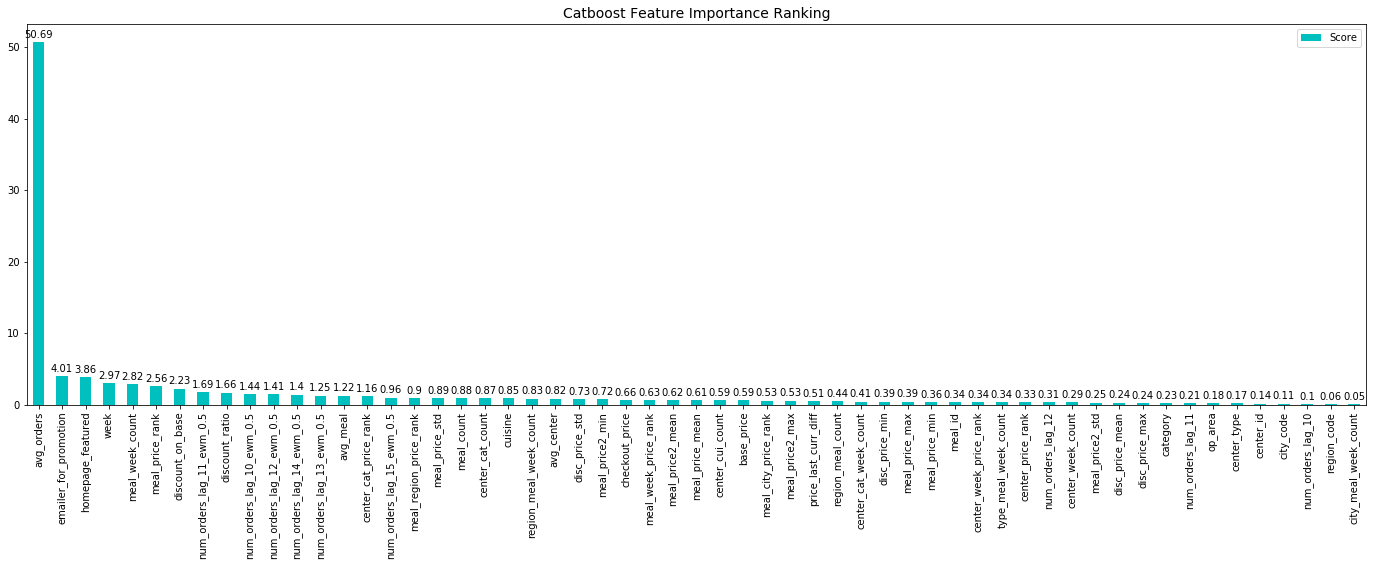

<Figure size 1728x504 with 0 Axes>

In [59]:
plt.rcParams["figure.figsize"] = (24,7)
ax = feature_score.plot('Feature', 'Score', kind='bar', color='c')
ax.set_title("Catboost Feature Importance Ranking", fontsize = 14)
ax.set_xlabel('')

rects = ax.patches

labels = feature_score['Score'].round(2)

for rect, label in zip(rects, labels):
    height = rect.get_height()
    ax.text(rect.get_x() + rect.get_width()/2, height + 0.35, label, ha='center', va='bottom')

plt.show()
plt.savefig("Importance of features")

In [48]:
import pickle
pickle.dump(model,open('model.pkl', 'wb'))

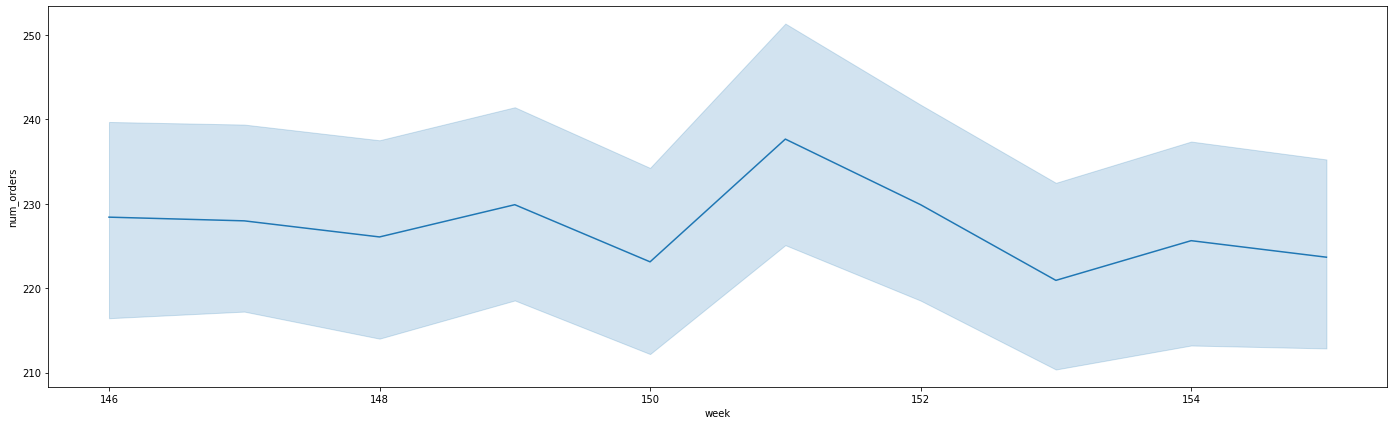

<Figure size 1728x504 with 0 Axes>

In [57]:
sns.lineplot(test['week'],submission['num_orders'])
plt.show()
plt.savefig("Number of order Vs Next 10 weeks")